# Hematopoietic stem cell RNA-Seq analysis
This analysis compares the change of gene expression of mouse hematopoietic stem cells (HSCs) comparing 24-month-old individuals to 4-month-old. This analysis also shows how Rosely can help to identify problems un-noticed by researchers and eliminate the introduced false significance. 

This example assumes that you are familiar with the parameters of Rosely functions. If not, please read [the example on monocyte RNA-seq data analysis](https://github.com/yjiangnan/rosely/blob/master/examples/human_classical_vs_nonclassical_monocyte_study_RNA-seq_analysis.ipynb) first.

First, we import analysis tools.

In [1]:
import sys, imp, time, pandas as pd
%pylab inline
import scipy.stats as ss
if 'rudolphLab/scripts' not in sys.path: sys.path.insert(0, '/Users/jiangnan/Documents/rudolphLab/scripts')
import rosely
imp.reload(rosely)
from rosely import *

Populating the interactive namespace from numpy and matplotlib
Rosely version: 1.3.0
import time: 2019-05-14 20:26:42.868746+02:00
Rosely version: 1.3.0
import time: 2019-05-14 20:26:42.871990+02:00


## Load count data:
The data is downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE47817, with unnecessary colums deleted.

Sun D, Luo M, Jeong M, Rodriguez B et al. Epigenomic profiling of young and aged HSCs reveals concerted changes during aging that reinforce self-renewal. Cell Stem Cell 2014 May 1;14(5):673-88. PMID: 24792119

Normalize different samples by the average of the 25% all rows whose mean counts are just above the the medium of expressed genes with mean count above a threshold.

In [2]:
hsc = CountReads('GSE47817_deg.m04_hsc_vs_m24_hsc.txt')
hsc.normalize_data(normalize_by='upper quantile4', normcutoff=10)
print('Library size:', len(hsc.seqids))
groups = list(hsc.presences.keys())
print('groups:', groups)
hsc.nRefs

Library size: 38172
groups: ['m04', 'm24']


{('m04', 'hsc_l1'): 1544.3896046201687,
 ('m04', 'hsc_l2'): 1551.2172367836517,
 ('m04', 'hsc_l3'): 1533.8107507774323,
 ('m04', 'hsc_l4'): 1536.9298089737895,
 ('m24', 'hsc_l1'): 1518.6628165259885,
 ('m24', 'hsc_l2'): 1538.3325188804974,
 ('m24', 'hsc_l3'): 1607.4704575744113,
 ('m24', 'hsc_l4'): 1611.2880941803642}

## Distribution of reads

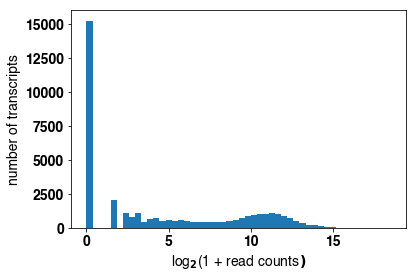

In [3]:
group = hsc.data[groups[0]]
d = log2(1 + array(group[list(group.keys())[0]].values))
hist(d[abs(d)<10000], 50);
xlabel('log$_2$(1 + read counts$ ^{{}} )$'); ylabel('number of transcripts');

## First attempt to identify differentially expressed genes by ascertained *t*-test
There are two groups, m04 and m24, each with four samples. Because it was young vs. old comparison, the samples should be most likely unpaired. 

0.423; iterations:0 r0:0.193, re:0.395, a:0.77000 lsq para:[-0.00445976 -0.12451316]
iterations:1 r0:0.110, re:0.332, a:0.65732 lsq para:[-0.03673744 -0.24788111]
iterations:2 r0:0.071, re:0.304, a:0.61468 lsq para:[-0.04273586 -0.2232511 ]
iterations:3 r0:0.054, re:0.290, a:0.59581 lsq para:[-0.04619391 -0.21465382]
iterations:4 r0:0.046, re:0.284, a:0.58779 lsq para:[-0.04817602 -0.21625888]
iterations:5 r0:0.042, re:0.282, a:0.58433 lsq para:[-0.04909252 -0.21748732]
iterations:6 r0:0.041, re:0.281, a:0.58285 lsq para:[-0.04946507 -0.21767819]
iterations:7 r0:0.041, re:0.280, a:0.58231 lsq para:[-0.04957861 -0.21742468]
iterations:8 r0:0.040, re:0.280, a:0.58216 lsq para:[-0.04961157 -0.21735819]
finetune para: [0.56385649429213136, -0.33478454078869452, 1.9998155828674942]  raw aa: 0.582155846534
total iterations:9 r0:0.040, re:0.280, last a:0.58216
power of p-values: fit: 0.5639, base: 0.7376, final:0.4159
shape (dimensions) of results: (17487, 4)


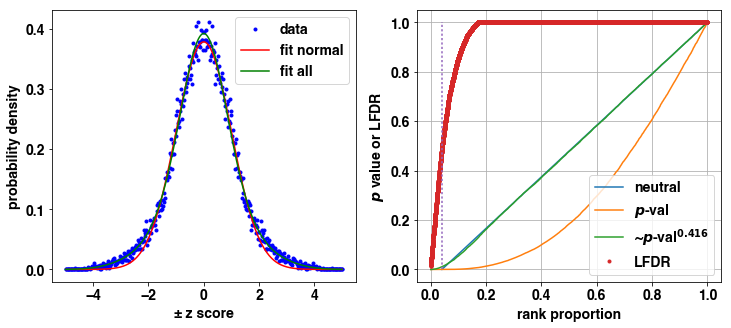

In [4]:
res = count_analysis([hsc.normdata['m04'], hsc.normdata['m24']], transform='log5', minmean=10);

## Interpretation
The power of *p*-values is small, even though the experiment was done in lab mice in controlled conditions. Something weird is happening. The first thing we would suspect is that the replicates were not commonly descended and identically maintained (CODIM) replicates and have strong within-group sample correlations. To prove this, we can plot a correlation heatmap among samples.
Darker color indicates that the sample pair is more dissimilar. This heatmap confirms the high similarities between adjacent replicates:

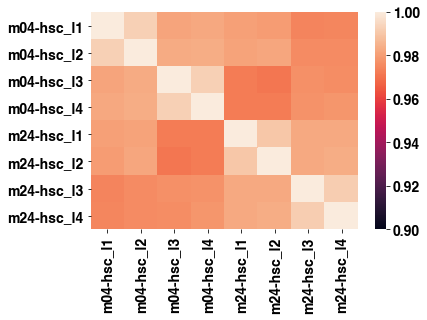

In [5]:
hsc.correlation_heatmap(vmin=0.9);

## Inflated significance caused by using technical replicates as independent replicates
If we dig into the experimental details of the data described in https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE47817, we can find that although there were four samples for each age group, there were only "biological duplicates". The description was not clear enough about how the samples were designed, but combined with our analysis above, it is clear that they sequenced only two mice for each age group, with each mouse sequenced with techinical duplicates. 

However, from the extremely small *p*-values in their paper and the large number (>2500) of genes they identified, it seems that they actually treated the technical replicates as independent replicates as we have done above. This is wrong. Additionally, using techinical replicates is a waste of resource. It would be really much better if they have used four biological replicates in each age group. The mice are not so expensive, but the sequencing is, especially given the high depth of their sequencing.

So, We have to combine technical replicates based on the above correlation heatmap:

In [6]:
m04 = {'l1l2': hsc.normdata['m04']['hsc_l1'] + hsc.normdata['m04']['hsc_l2'],
       'l3l4': hsc.normdata['m04']['hsc_l3'] + hsc.normdata['m04']['hsc_l4']}
m24 = {'l1l2': hsc.normdata['m24']['hsc_l1'] + hsc.normdata['m24']['hsc_l2'],
       'l3l4': hsc.normdata['m24']['hsc_l3'] + hsc.normdata['m24']['hsc_l4']}

## Analysis by ascertained t-test
This part identifies the differentially expressed genes (DEGs) by ascertained t-test. The neutrality-controlled p-values are controlled in such a way that most genes will have values expected by random chance so that the identified genes really stand out compared to most other genes. Local false discovery rate (LFDR) is the chance for each gene to be false discovery. 

As you can find in the following figure, inflated significance in the *p*-values is almost completely removed after combining the technical replicates, demonstrating the power of Rosely to identify experimental design problems even the researchers themselves could not recognize. 

0.902; iterations:0 r0:0.055, re:0.291, a:0.98527 lsq para:[-0.59677708 -4.32261801]
iterations:1 r0:0.052, re:0.289, a:0.97831 lsq para:[-0.43572924 -3.10301566]
iterations:2 r0:0.050, re:0.288, a:0.97605 lsq para:[-0.4046295  -2.86955309]
iterations:3 r0:0.050, re:0.287, a:0.97513 lsq para:[-0.39348903 -2.78584743]
iterations:4 r0:0.050, re:0.287, a:0.97473 lsq para:[-0.38896218 -2.75178313]
finetune para: [0.98233135179096831, -5.4055631153460126e-05, 2.0]  raw aa: 0.974729803135
total iterations:5 r0:0.050, re:0.287, last a:0.97473
power of p-values: fit: 0.9823, base: 0.9747, final:0.9575
shape (dimensions) of results: (19056, 4)
dt: 43.89172387123108
Top 10 differentially expressed genes:


,LFDR,Controlled z-score,Controlled p-value,log2 fold change
Clca1,0.000608,5.520707,3.376382e-08,2.488958
Col1a1,0.000859,-5.328324,9.912331e-08,-4.348614
Selp,0.000899,5.304648,1.128908e-07,2.396309
Ltf,0.001074,-5.215972,1.828561e-07,-3.136728
Clu,0.001199,5.162643,2.434869e-07,2.275766
Plscr2,0.001217,5.155663,2.527355e-07,2.795005
Matn4,0.001297,5.125727,2.963911e-07,2.935058
Sult1a1,0.001344,5.109341,3.232844e-07,2.006355
Klrb1c,0.001740,4.992369,5.964308e-07,2.887209
"AK031816,AK141638,AK165889",0.001805,4.976316,6.480580e-07,1.786149


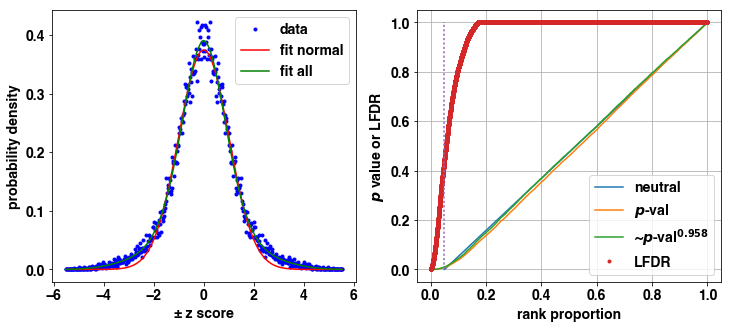

In [7]:
t0 = time.time()
res = count_analysis([m04, m24], transform='log5', minmean=10, debug=True);
print('dt:', time.time() - t0)
print('Top 10 differentially expressed genes:')
res.results.head(n=10)

## Save to file

In [8]:
import os
if not os.path.isdir('GoodellLSK'): os.mkdir('GoodellLSK')
res.results.to_excel('GoodellLSK/GoodellLSK_young_vs_old.RNA-seq.DEGs.xlsx')

## Internal of ascertained *t*-test: distribution of normalized variance of genes
The variances of all genes were first normalized by raising to a power in each group so that the gap between the mean and median divided by the standard deviation of transformed values was minimized.

Sampling standard deviation (SD) is the amount of variation of transformed values expected by random chance.

Prior gene SD is the expected SD of the true population variances of all genes.

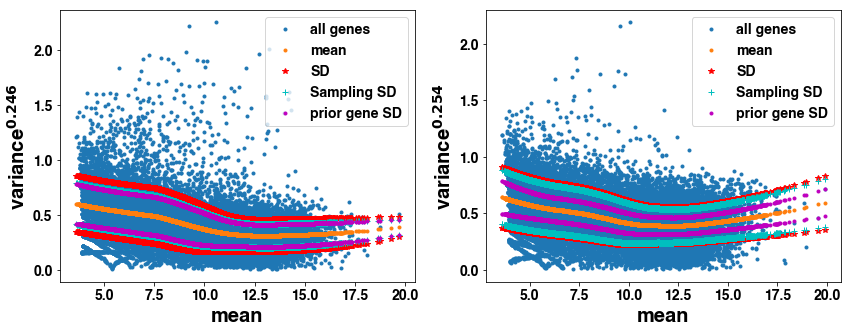

In [9]:
res.plot_variance()

## Total number of genes with LFDR < 0.2 and LFDR < 0.4
LFDR (local false discovery rate) is the chance for a gene to be false discovery after adjustment for multiple comparisons.

In [10]:
sum(res.LFDR<0.2)

520

In [11]:
sum(res.LFDR<0.4)

853

## Gene Ontology analysis
### Load ontology data:

In [12]:
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()
obodag = GODag(obo_fname)
geneid2gos_mouse = read_ncbi_gene2go(gene2go, taxids=[10090])

  EXISTS: go-basic.obo
  EXISTS: gene2go
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2018-05-28) 47,248 GO Terms
  19,989 items READ: gene2go


### Use all analyzed genes as population (background)

In [13]:
rr = res.update_gene_ids(species='mouse')

Symbol corrections: 9-Mar --> March9; 6-Sep --> Sept6; 11-Sep --> Sept11; 6-Mar --> March6; 8-Sep --> Sept8; 15-Sep --> Sep15; 8-Mar --> March8; 4-Sep --> Sept4; 7-Sep --> Sept7; 2-Sep --> Sept2; 3-Mar --> March3; 9-Sep --> Sept9; 1-Sep --> Sept1; 2-Mar --> March2; 1-Mar --> March1; 3-Sep --> Sept3; 7-Mar --> March7; 10-Sep --> Sept10; 5-Mar --> March5; 
Querying ensemblgene,symbol 1 ~ 1000 1001 ~ 2000 2001 ~ 3000 3001 ~ 4000 4001 ~ 5000 5001 ~ 6000 6001 ~ 7000 7001 ~ 8000 8001 ~ 9000 9001 ~ 10000 10001 ~ 11000 11001 ~ 12000 12001 ~ 13000 13001 ~ 14000 14001 ~ 15000 15001 ~ 16000 16001 ~ 17000 17001 ~ 18000 18001 ~ 19000 19001 ~ 19056 


In [14]:
from goatools.ratio import get_terms
population = rr.index
go2popitems = get_terms("population", population, geneid2gos_mouse, obodag, None)
GOs = {'biological_process':{}, 'cellular_component':{}, 'molecular_function':{}}
for go in sorted(go2popitems): 
    if len(go2popitems[go]) >= 10: # Pre-clean GO terms unlikely to be significant (too few genes in population)
        GOs[obodag[go].namespace][go] = {'geneid':go2popitems[go], 'name':obodag[go].name}

### Gene Ontology analysis for the enrichment of the top genes with LFDR < 0.4

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0007155,cell adhesion,3.689820e-09,1.044247e-13,51 / 682,311 / 13553,3.26,51,311,"Cntn1 2.99, Vmp1 0.85, Lama5 1.03, Fap 2.1, Al..."
GO:0007018,microtubule-based movement,1.016071e-04,5.508480e-08,18 / 682,76 / 13553,4.71,18,76,"Myo6 0.78, Kif20b -0.75, Kif11 -0.71, Kif15 -0..."
GO:0050919,negative chemotaxis,4.815122e-04,4.971705e-07,10 / 682,26 / 13553,7.64,10,26,"Itgb3 1.33, Sema4f 1.44, Sema6a 1.84, Sema7a 0..."
GO:0008284,positive regulation of cell proliferation,8.449752e-04,1.133266e-06,41 / 682,355 / 13553,2.30,41,355,"Igf1 -1.62, Mab21l2 5.11, Kif20b -0.75, Rasip1..."
GO:0048754,branching morphogenesis of an epithelial tube,1.080310e-03,1.633717e-06,10 / 682,29 / 13553,6.85,10,29,"Igf1 -1.62, Mycn 0.77, Lama5 1.03, Gli2 -1.69,..."
GO:0030324,lung development,1.663363e-03,3.135529e-06,15 / 682,70 / 13553,4.26,15,70,"Igf1 -1.62, Bmpr1a 2.42, Mycn 0.77, Lama5 1.03..."
GO:0048843,negative regulation of axon extension involved...,1.833323e-03,3.638347e-06,8 / 682,19 / 13553,8.37,8,19,"Sema4f 1.44, Sema6a 1.84, Sema7a 0.94, Wnt5a 2..."
GO:0042493,response to drug,2.054558e-03,4.334380e-06,18 / 682,100 / 13553,3.58,18,100,"Myo6 0.78, Abcc9 -1.88, Fos -3.14, Srd5a1 0.96..."
GO:0008285,negative regulation of cell proliferation,4.474848e-03,1.473094e-05,33 / 682,286 / 13553,2.29,33,286,"Igf1 -1.62, Irf6 0.68, Hmox1 -0.89, Lmna -0.91..."
GO:0007411,axon guidance,5.597099e-03,2.114277e-05,15 / 682,81 / 13553,3.68,15,81,"Sema4f 1.44, Efna1 1.21, Sema6a 1.84, Gli2 -1...."


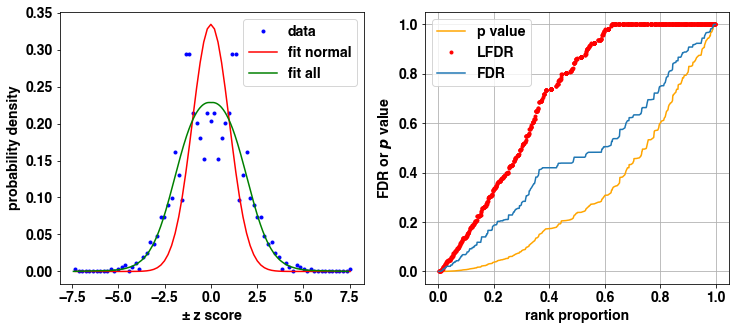

In [15]:
top_genes = rr[rr['LFDR']<0.4].index
goenriched = enrichment_analysis(top_genes, population, GOs['biological_process'], tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
goenriched[goenriched['LFDR']<0.4].head(n=30)

### Save the analysis to file
The file also contains the associated genes (and log$_2$ fold chnage) and LFDR.

In [16]:
goenriched[goenriched['LFDR']<0.4].to_csv("GoodellLSK/GoodellLSK_young_vs_old.RNA-seq.Gene_Ontology_analysis.csv")

## KEGG pathway analysis
rosely.pathwayanalysis is used for analysis. This module is dependent on BioPython.
### Load KEGG data:

In [17]:
pathways = load_all_kegg_pathways(species_code='mmu')

### Gene enrichment in KEGG pathways for the top genes with LFDR < 0.4

Enriched pathways (fold = study / background):


,Pathways,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
path:mmu04514,Cell adhesion molecules (CAMs),5.150699e-07,2.487292e-10,24 / 682,101 / 13553,4.72,24,101,"Cd276 1.19, Cntn1 2.99, Alcam 1.41, Nrxn2 1.22..."
path:mmu05200,Pathways in cancer,1.933180e-04,7.120677e-07,46 / 682,414 / 13553,2.21,46,414,"Igf1 -1.62, Lama5 1.03, Hmox1 -0.89, Itga2 -0...."
path:mmu05418,Fluid shear stress and atherosclerosis,2.790594e-04,1.176094e-06,21 / 682,121 / 13553,3.45,21,121,"Bmpr1a 2.42, Hmox1 -0.89, Gstm2 2.37, Pik3cd -..."
path:mmu04610,Complement and coagulation cascades,3.712825e-04,1.739925e-06,12 / 682,43 / 13553,5.55,12,43,"Thbd 0.76, Vwf 1.58, C7 1.6, C1qa -1.15, C1qc ..."
path:mmu04974,Protein digestion and absorption,7.890923e-04,4.923740e-06,12 / 682,47 / 13553,5.07,12,47,"Col5a2 -2.86, Col6a1 -1.46, Col1a1 -4.35, Col1..."
path:mmu04640,Hematopoietic cell lineage,9.715759e-04,6.571850e-06,15 / 682,74 / 13553,4.03,15,74,"Itgb3 1.33, Il9r -1.71, Cd33 -2.12, Cd34 -0.97..."
path:mmu04512,ECM-receptor interaction,2.795071e-03,2.883787e-05,13 / 682,64 / 13553,4.04,13,64,"Itgb3 1.33, Col6a1 -1.46, Vwf 1.58, Itgb5 -1.7..."
path:mmu05204,Chemical carcinogenesis,5.998242e-03,8.511663e-05,9 / 682,35 / 13553,5.11,9,35,"Sult1a1 2.01, Gstt1 0.64, Gstm2 2.37, Chrna7 2..."
path:mmu05150,Staphylococcus aureus infection,5.998242e-03,8.511663e-05,9 / 682,35 / 13553,5.11,9,35,"C1qa -1.15, C1qb -1.18, C1qc -1.1, C4b 2.44, H..."
path:mmu05020,Prion diseases,8.153038e-03,1.319450e-04,8 / 682,29 / 13553,5.48,8,29,"C1qa -1.15, C7 1.6, C1qb -1.18, C1qc -1.1, Hsp..."


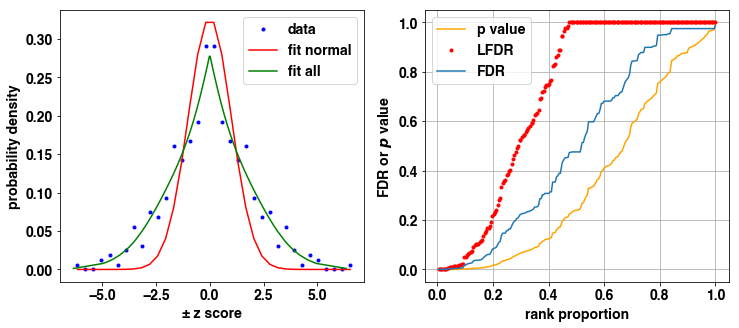

In [18]:
top_genes = rr[rr['LFDR'] < 0.4].index
enriched = enrichment_analysis(top_genes, population, pathways, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')

kegggenes = []
for pw in (enriched[enriched['LFDR']<0.4]).index:
    symbol = pathways[pw]['gene_symbol']
    kegggenes.extend(symbol)
print('Enriched pathways (fold = study / background):')
enriched[enriched['LFDR']<0.3]

## Save to file

In [19]:
enriched[enriched['LFDR']<0.4].to_excel('GoodellLSK/GoodellLSK_young_vs_old.RNA-seq.Gene_KEGG_pathway_enrichment.xlsx')

## Draw the pathways to file
The color of the boxes indicates statistical significance and is calculated as neutrality-controlled z-scores times their absolute values. Positive values are shown in red, indicating evidence for up-regulation in old; negative values in blue.

In [20]:
draw_kegg_pathways(enriched[enriched['LFDR']<0.3], rr, overlap_cutoff=2,
                   colorcolumn='Controlled z-score', folder='GoodellLSK/pathway images')

geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
geneid
15051.0    H2-T9
15051.0    H2-T9
Name: symbol, dtype: object is converted to H2-T9
